<a href="https://colab.research.google.com/github/amal274/Isamm20242025/blob/main/Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep inside: Autoencoders

This notebook is the complement of [this blog post](https://towardsdatascience.com/deep-inside-autoencoders-7e41f319999f)

4 types of autoencoders are described using the Keras framework and the MNIST dataset

1. Vanilla autoencoders
2. Multilayer autoencoder
3. Convolutional autoencoder
4. Regularized autoencoder

## Import the libraries

In [ ]:
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, add
from tensorflow.keras.layers import Layer, Dense, Dropout, Activation, Flatten, Reshape
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from tensorflow.keras.utils import to_categorical

## Load the data

We don't need the labels as the autoencoders are unsupervised network

In [ ]:
(X_train, _), (X_test, _) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

## Normalize the data

We want the pixels values between 0 and 1 instead of between 0 and 255

In [ ]:
X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## Flatten the images for the Fully-Connected Networks

In [ ]:
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

___

# **Vanilla Autoencoder**

### Create the network

The first network is the most simple autoencoder. It has three layers : Input - encoded - decoded

In [ ]:
input_size = 784
hidden_size = 64
output_size = 784

In [ ]:
x = Input(shape=(input_size,))
h = Dense(hidden_size, activation='relu')(x)
r = Dense(output_size, activation='sigmoid')(h)

autoencoder = Model(inputs=x, outputs=r)
encoder = Model(inputs=x, outputs=h)

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K

radius = 1.0  # rayon de la sphère
alpha1 = 1.0   # pondération de la contrainte sphérique
alpha2= 0.0

def sphere_loss(x_true, x_pred):
    #(MSE)
    reconstruction_loss = K.mean(K.square(x_true - x_pred), axis=-1)

    h_latent = encoder(x_true)

    norm = K.sqrt(K.sum(K.square(h_latent), axis=1) + K.epsilon())

    sphere_penalty = K.square(norm - radius)

    #tf.print("Reconstruction Loss:", reconstruction_loss)
    #tf.print("Sphere Penalty:", sphere_penalty)

    total_loss = alpha1 * reconstruction_loss + alpha2 * sphere_penalty
    return total_loss


In [ ]:
autoencoder.compile(optimizer='adam', loss=sphere_loss)

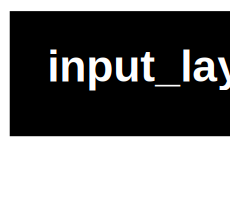

In [ ]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

### Train

In [ ]:
epochs = 5
batch_size = 128

history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1610 - val_loss: 0.0627
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0574 - val_loss: 0.0461
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0436 - val_loss: 0.0367
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0353 - val_loss: 0.0311
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0302 - val_loss: 0.0271


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


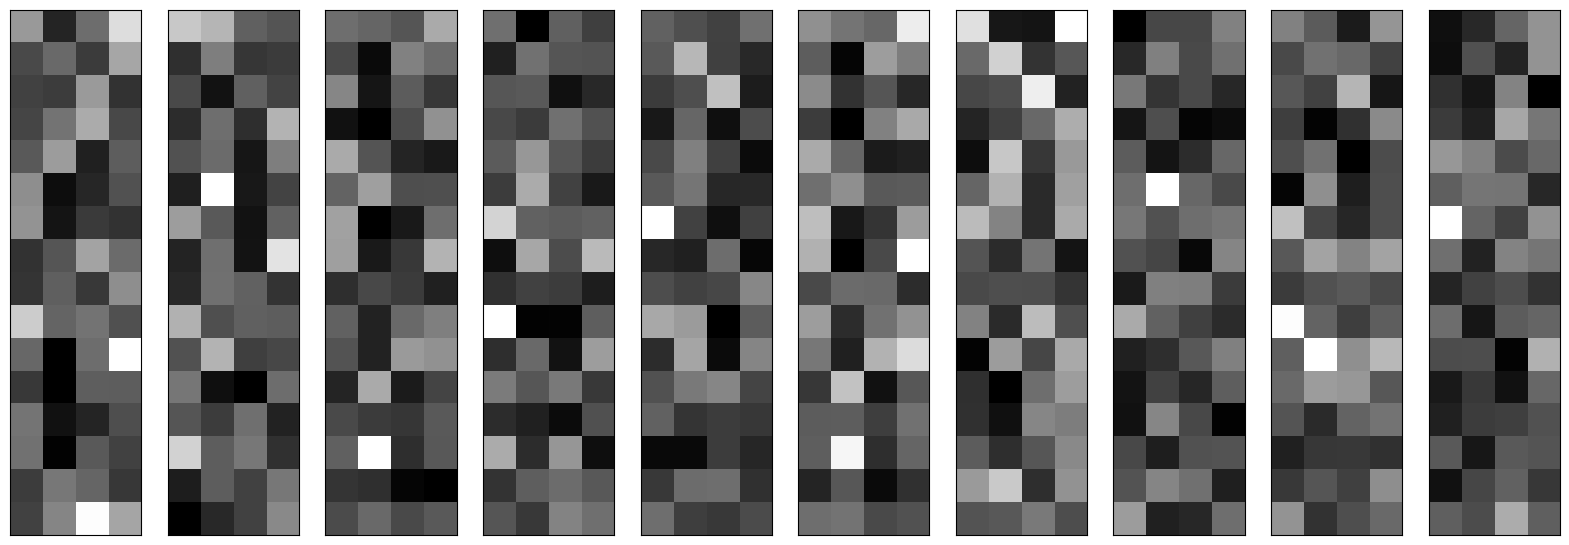

In [ ]:
conv_encoder = Model(x, h)
encoded_imgs = conv_encoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(4, 16).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Predict on the test set

In [ ]:
decoded_imgs = autoencoder.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


### Plot

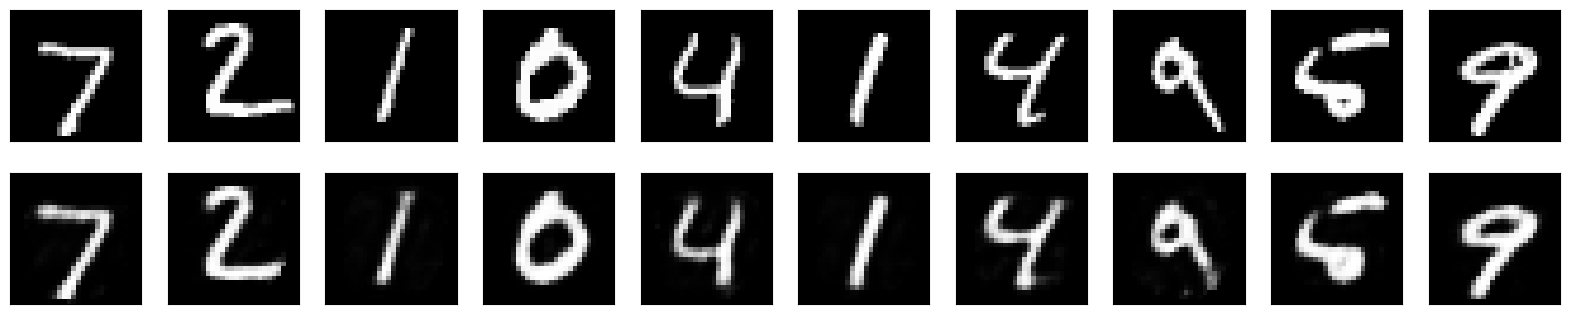

In [ ]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### Plot the losses

dict_keys(['loss', 'val_loss'])


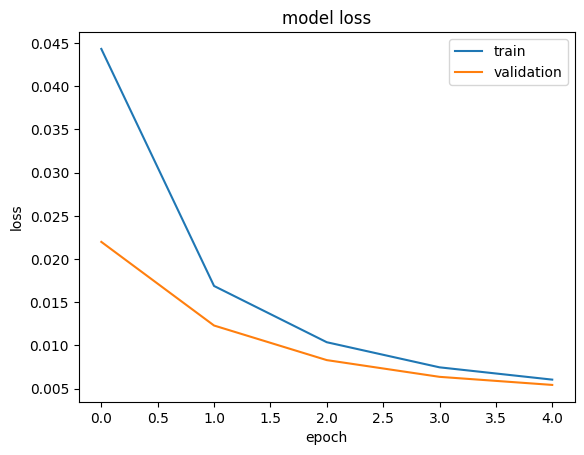

In [ ]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# alpha1 combiné (ordre décroissant : de 1.0 à 0.0)
alpha_values = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]

# Fusion des losses pour chaque epoch (set1 + set2)
losses_combined = {
    'epoch1': [0.0751, 0.0742, 0.1637, 0.1616, 0.1459, 0.1550, 0.1009, 0.1757, 0.1311, 0.1308, 0.1345],
    'epoch2': [0.0193, 0.0193, 0.0590, 0.0526, 0.0477, 0.0379, 0.0313, 0.0281, 0.0219, 0.0148, 0.0092],
    'epoch3': [0.0114, 0.0117, 0.0446, 0.0405, 0.0372, 0.0297, 0.0237, 0.0206, 0.0156, 0.0095, 0.0044],
    'epoch4': [0.0080, 0.0082, 0.0371, 0.0336, 0.0313, 0.0255, 0.0202, 0.0181, 0.0132, 0.0078, 0.0024],
    'epoch5': [0.0063, 0.0064, 0.0320, 0.0292, 0.0271, 0.0255, 0.0177, 0.0163, 0.0117, 0.0069, 0.0011]
}

# Tracer toutes les courbes
plt.figure(figsize=(12, 6))
for epoch in losses_combined:
    plt.plot(alpha_values, losses_combined[epoch], marker='o', label=epoch)

plt.xlabel("alpha1 (alpha2 = 1 - alpha1)")
plt.ylabel("Total Loss")
plt.title("Évolution continue de la perte en fonction de alpha1")
plt.legend()
plt.grid(True)
plt.gca().invert_xaxis()  # Pour que alpha1 diminue de gauche à droite
plt.tight_layout()
plt.show()


---

# **Multilayer autoencoder**

### Create the network

We extend the idea of the first network to more layers

In [ ]:
input_size = 784
hidden_size = 128
code_size = 64

x = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(x)
h = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(h)
r = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='mse')

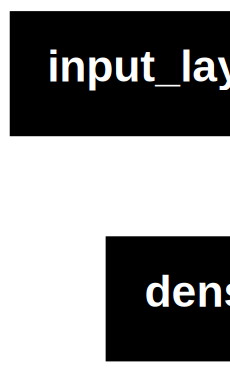

In [ ]:
from IPython.display import SVG
from  tensorflow.keras.utils import model_to_dot

SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

### Train the network

In [ ]:
epochs = 5
batch_size = 128

history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.0680 - val_loss: 0.0189
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0172 - val_loss: 0.0126
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0124 - val_loss: 0.0104
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0104 - val_loss: 0.0090
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0090 - val_loss: 0.0081


### Predict on the test set

In [ ]:
decoded_imgs = autoencoder.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


### Plot

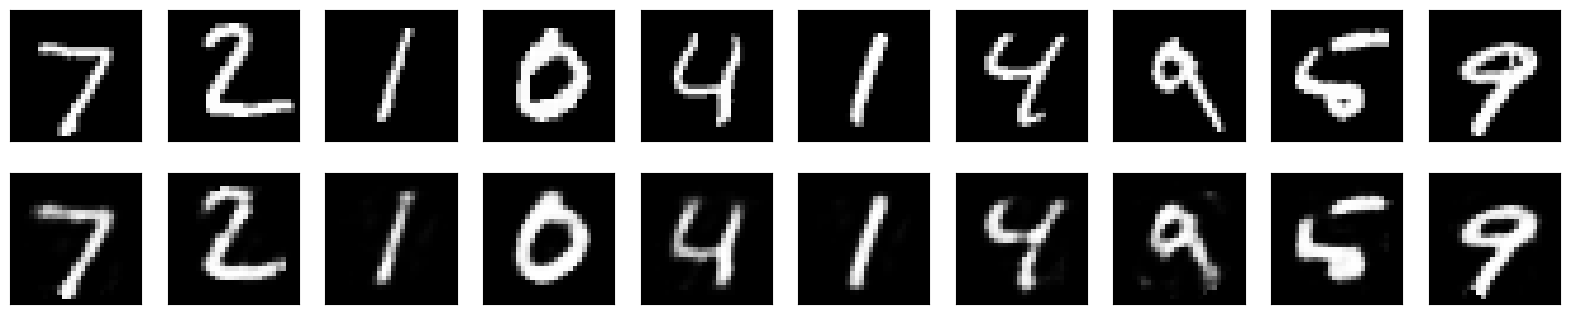

In [ ]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### Plot the losses

dict_keys(['loss', 'val_loss'])


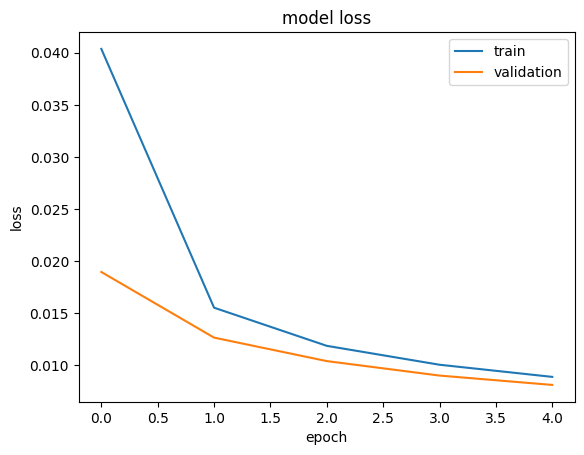

In [ ]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

___

# **Convolutional autoencoder**

In [ ]:
nb_classes = 10

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


### Create the network

This network does not take flattened vectors as an input but images

In [ ]:
x = Input(shape=(28, 28,1))

# Encoder
conv1_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1_1)
conv1_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D((2, 2), padding='same')(conv1_2)
conv1_3 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool2)
h = MaxPooling2D((2, 2), padding='same')(conv1_3)


# Decoder
conv2_1 = Conv2D(8, (3, 3), activation='relu', padding='same')(h)
up1 = UpSampling2D((2, 2))(conv2_1)
conv2_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(up1)
up2 = UpSampling2D((2, 2))(conv2_2)
conv2_3 = Conv2D(16, (3, 3), activation='relu')(up2)
up3 = UpSampling2D((2, 2))(conv2_3)
r = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up3)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

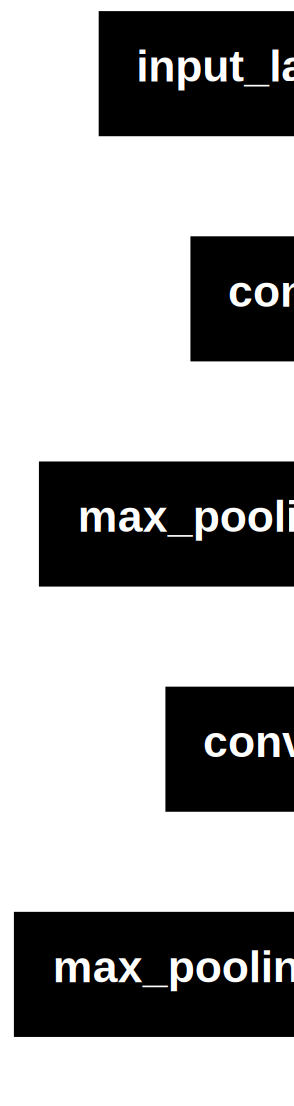

In [ ]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

### Train

In [ ]:
epochs = 3
batch_size = 128

history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

Epoch 1/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 72s 145ms/step - loss: 0.6841 - val_loss: 0.6792
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 67s 143ms/step - loss: 0.6768 - val_loss: 0.6678
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 87s 153ms/step - loss: 0.6630 - val_loss: 0.6436


In [ ]:
decoded_imgs = autoencoder.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step


### Plot

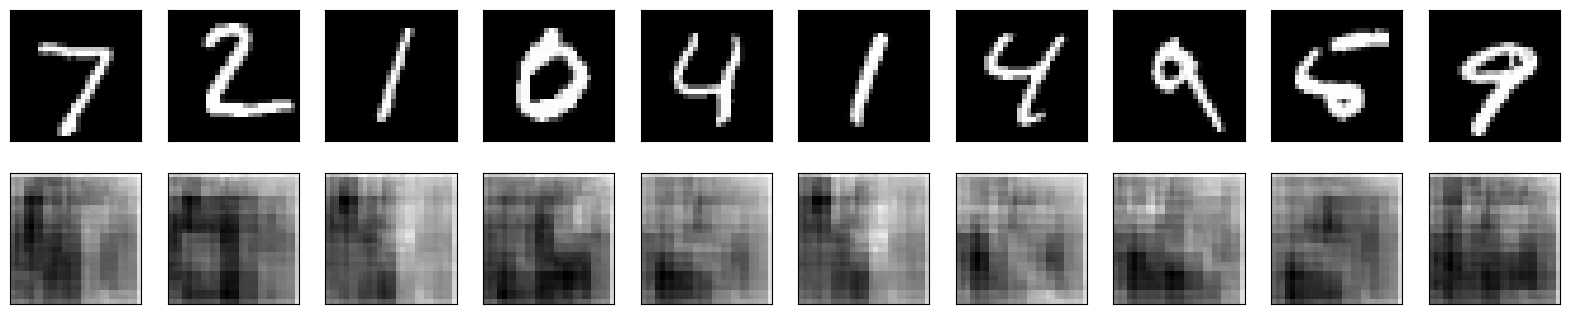

In [ ]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### Plot the losses

dict_keys(['loss', 'val_loss'])


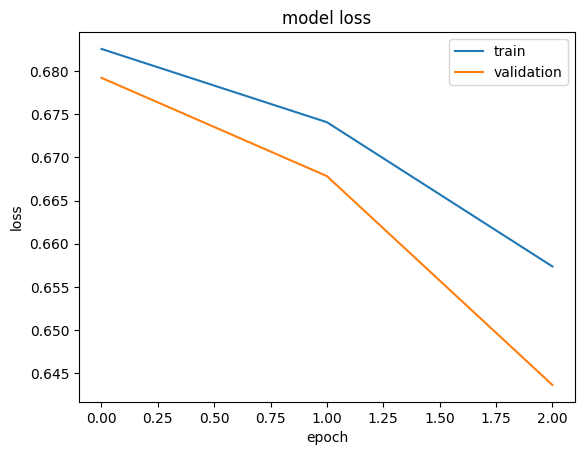

In [ ]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

___

# **Regularized autoencoder**

Two types of regularization are described :
- Sparse autoencoder
- Denoising autoencoder

## 1. Sparse autoencoder

### Create the network

In [ ]:
input_size = 784
hidden_size = 32
output_size = 784

In [ ]:
x = Input(shape=(input_size,))
h = Dense(hidden_size, activation='relu', activity_regularizer=regularizers.l1(10e-5))(x)
r = Dense(output_size, activation='sigmoid')(h)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='mse')

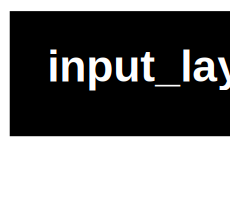

In [ ]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

In [ ]:
epochs = 15
batch_size = 128


history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2145 - val_loss: 0.1633
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1516 - val_loss: 0.1243
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1176 - val_loss: 0.1025
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0987 - val_loss: 0.0901
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0877 - val_loss: 0.0826
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0811 - val_loss: 0.0780
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0769 - val_loss: 0.0749
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0742 - val_loss: 0.0729
Epoch 9/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0722 - val_loss: 0.0714
Epoch 10/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0708 - val_loss: 0.0704
Epoch 11/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0699 - val_loss: 0.0697
Epoch 12/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/ste

### Predict on the test set

In [ ]:
decoded_imgs = autoencoder.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


### Plot

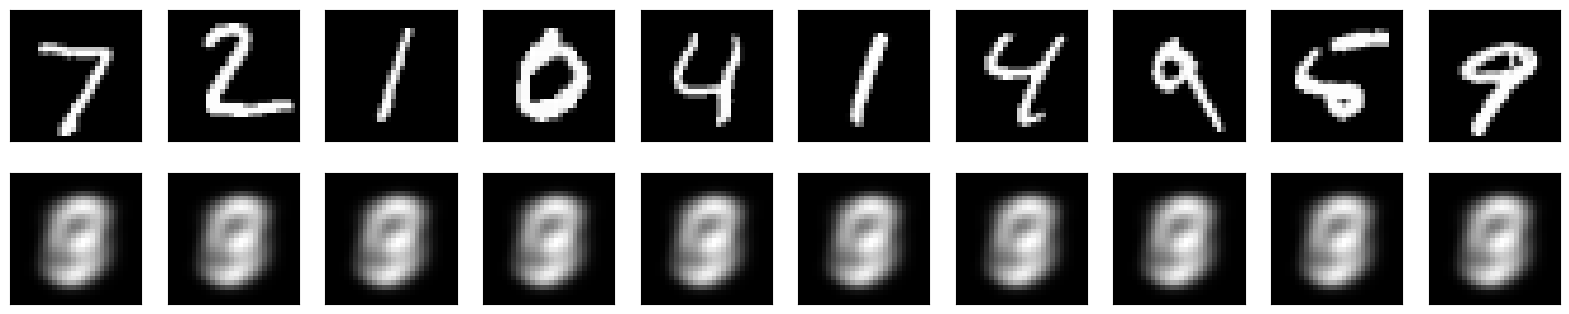

In [ ]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### Plot the losses

dict_keys(['loss', 'val_loss'])


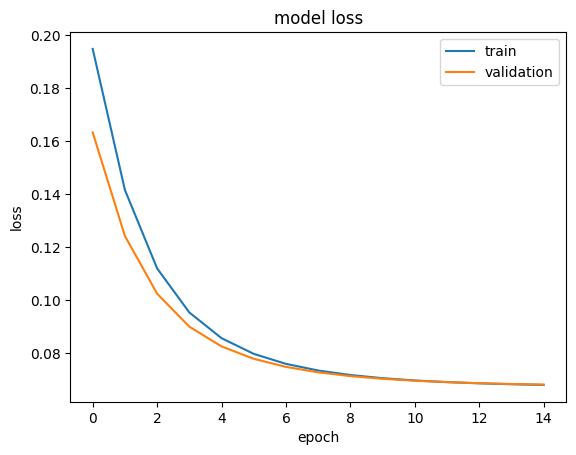

In [ ]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## 2. Denoising autoencoder

In [ ]:
(X_train, _), (X_test, _) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.

### Create noisy data

In [ ]:
noise_factor = 0.5
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

### Create the network

In [ ]:
x = Input(shape=(28, 28, 1))

# Encoder
conv1_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1_1)
conv1_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
h = MaxPooling2D((2, 2), padding='same')(conv1_2)


# Decoder
conv2_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(h)
up1 = UpSampling2D((2, 2))(conv2_1)
conv2_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
up2 = UpSampling2D((2, 2))(conv2_2)
r = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

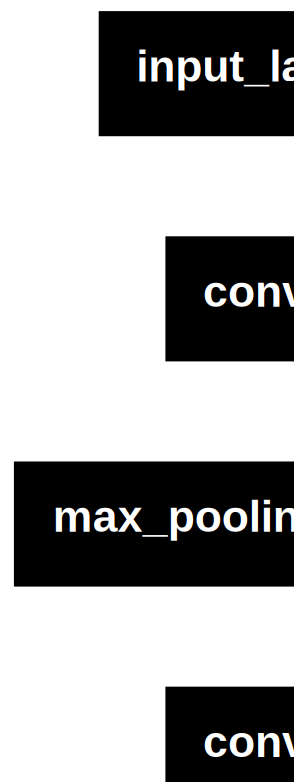

In [ ]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

### Train the network

In [ ]:
epochs = 3
batch_size = 128

history = autoencoder.fit(X_train_noisy, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test_noisy, X_test))

Epoch 1/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 131s 274ms/step - loss: 0.6888 - val_loss: 0.6600
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 272ms/step - loss: 0.6461 - val_loss: 0.5936
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 148s 285ms/step - loss: 0.5714 - val_loss: 0.5243


In [ ]:
decoded_imgs = autoencoder.predict(X_test_noisy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


### Plot

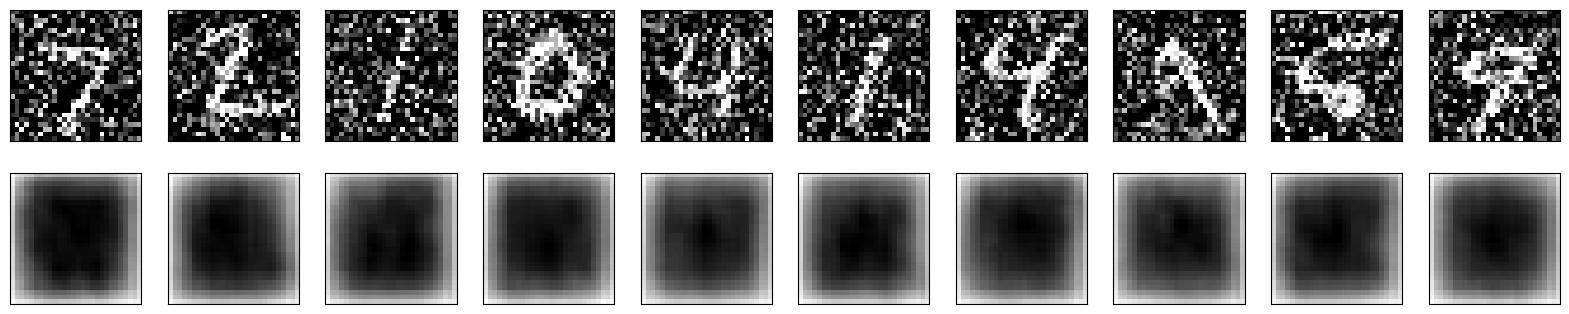

In [ ]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### Plot the losses

dict_keys(['loss', 'val_loss'])


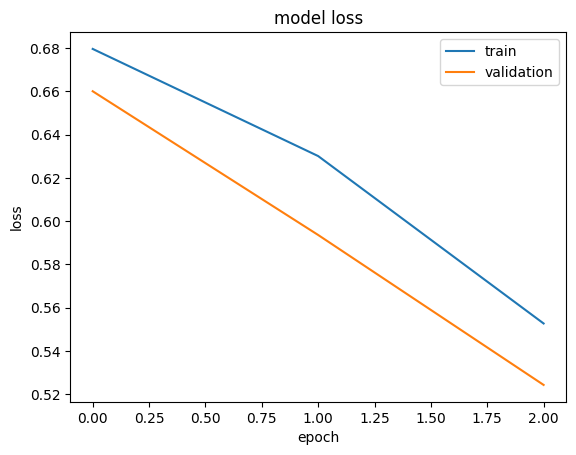

In [ ]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

___

---